# WeatherPy
----

#### Note
* Uses Open Weather API - use https://openweathermap.org/api to acquire an API key and as reference for how to monitor your usage and billing.

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from time import gmtime,strftime
from scipy.stats import linregress
import os

# Import API key
from config import weather_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output Date (for csv and images)
output_date = strftime("%m%d%Y",gmtime())
output_path = "output/%s/" % output_date

# API variables
query_url = "http://api.openweathermap.org/data/2.5/weather?units=imperial&appid=%s&q=" % weather_key

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Plot Generator Functions

In [2]:
def buildLatPlot(y, ylabel, df, grid=False, title_prefix = "", linregress=False, save=False):
    x_val = df["Lat"]
    y_val = df[y]
    
    # X limits
    x_min = x_val.min()
    x_max = x_val.max()
    x_lim = getLimits(x_min, x_max, 10)
    
    # Y limits
    y_min = y_val.min()
    y_max = y_val.max()
    y_lim = getLimits(y_min, y_max, 5)
    
    # Create title
    date = strftime("%m/%d/%Y",gmtime())
    title = "{0}City Latitude vs. {1}: {2}".format(title_prefix,ylabel,date)
    
    # Create and show plot
    lat_plt = df.plot(kind="scatter", x="Lat", y=y, grid=grid,
                       edgecolor="black", facecolor="blue", alpha=.75,
                       xlim=x_lim, ylim=y_lim, title=title)
    xlabel = "Latitude"
    lat_plt.set_xlabel(xlabel)
    lat_plt.set_ylabel(ylabel)
    lat_plt.axvline(0, color='black', linestyle='-', linewidth='3')
    
    # If desired, add the linear regression line and equation to the plot
    if linregress is True:
        x = {
            "values": x_val,
            "min": x_min,
            "max": x_max
        }
        y = {
            "values": y_val,
            "min": y_min,
            "max": y_max
        }
        addLinregress(x,y,lat_plt)
    
    # If desired, save the plot as a png in the output folder
    if save is True:
        output_ylabel = " ".join(ylabel.split()[:-1])
        #check if today already has a directory
        if os.path.isdir(output_path) is False:
            createNewDir(output_path)
        lat_plt.figure.savefig("{0}{1}{2}-{3}.png".format(output_path,title_prefix,xlabel,output_ylabel))

In [3]:
# Gets the limits of the chart based on the minimum and maximum values
# The landmark value is what to round to so no plot points are chopped off when the plot renders
def getLimits(in_min, in_max, landmark):
    # get minimum
    if in_min <= 0:
        out_min = in_min-(landmark-(abs(in_min)%landmark))
    else:
        out_min = in_min-(in_min%landmark)
    # get maximum
    if in_max >= 0:
        out_max = in_max+(landmark-(in_max%landmark))
    else:
        out_max = in_max+(abs(in_max)%landmark)
    return (out_min,out_max)

In [4]:
# Add linear regression line and equation to the plot
def addLinregress(x,y,lat_plt):
    # get linear regression values and plot the line
    slope, intercept, rvalue, pvalue, stderr = linregress(x["values"], y["values"])
    lin_val = slope*x["values"] + intercept
    lat_plt.plot(x["values"],lin_val,"-",color="red")
    
    # create the equation string
    lin_eq = "y = {0}x + {1}".format(round(slope,2),round(intercept,2))
    
    # create coordinates for linear regression equation based on slope to try and minimize collision the data
    lin_x_buffer = (abs(.05*(x["min"]+x["max"])))
    lin_x = x["min"]+lin_x_buffer
    
    lin_y_buffer = (abs(.1*(y["min"]+y["max"])))
    if slope > -1:
        lin_y = y["max"]-lin_y_buffer
    else:
        lin_y = y["min"]+lin_y_buffer
    
    # add to existing plot
    lat_plt.annotate(lin_eq,(lin_x, lin_y),fontsize=15,color="red")
    
    # print r value
    print(f"The r-value is: {rvalue}")

In [5]:
# Create a date-specific folder
def createNewDir(path):
    try:
        os.mkdir(path)
    except OSError:
        print ("Failed to create directory for %s. Saving to output/" % path)
        output_path = "output/"
    else:
        print ("Created directory for %s" % path)

## Generate Cities List

In [6]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)

# Print the city count to confirm sufficient count
len(cities)

601

### Perform API Calls

In [7]:
# Print title and divider
print_title = "Beginning Data Retrieval"
print(print_title)
print(len(print_title)*"-")

# Request weather data from every city in list
# Instantiate counters and city list
record = 1
rec_set = 1
city_list = []

# Loop through the cities and store the api response
for city in cities:
    response = requests.get(query_url + city).json()
    # if the response doesn't have a name, skip adding it to the city list and do not increment
    try:
        print(f"Processing Record {record} of Set {rec_set} | {response['name']}")
    except KeyError:
        print("City not found. Skipping...")
    else:
        city_list.append(response)
        if record == 50:
            record = 1
            rec_set += 1
        else:
            record += 1
    # Lastly, wait a second before making another call to stay under 60 calls per minute limit
    finally:
        time.sleep(1)

Beginning Data Retrieval
------------------------
Processing Record 1 of Set 1 | Hong Kong
Processing Record 2 of Set 1 | Vakhrushev
Processing Record 3 of Set 1 | Khanbari
Processing Record 4 of Set 1 | Chardara
Processing Record 5 of Set 1 | Port Alfred
Processing Record 6 of Set 1 | Port Elizabeth
Processing Record 7 of Set 1 | Hilo
Processing Record 8 of Set 1 | Fortuna
Processing Record 9 of Set 1 | Pangody
Processing Record 10 of Set 1 | Cap-aux-Meules
Processing Record 11 of Set 1 | Athabasca
Processing Record 12 of Set 1 | Ushuaia
Processing Record 13 of Set 1 | Mareeba
Processing Record 14 of Set 1 | Dunedin
Processing Record 15 of Set 1 | Kamiiso
Processing Record 16 of Set 1 | Portland
Processing Record 17 of Set 1 | Saint Paul Harbor
Processing Record 18 of Set 1 | Rikitea
City not found. Skipping...
City not found. Skipping...
Processing Record 19 of Set 1 | Chui
Processing Record 20 of Set 1 | Hobart
Processing Record 21 of Set 1 | Saint-Philippe
Processing Record 22 of S

Processing Record 34 of Set 4 | Hailar
Processing Record 35 of Set 4 | Puerto Escondido
Processing Record 36 of Set 4 | Geraardsbergen
Processing Record 37 of Set 4 | Richards Bay
Processing Record 38 of Set 4 | Ketchikan
Processing Record 39 of Set 4 | Aklavik
City not found. Skipping...
Processing Record 40 of Set 4 | Ridgecrest
Processing Record 41 of Set 4 | Asău
Processing Record 42 of Set 4 | Pandan
Processing Record 43 of Set 4 | Ancud
Processing Record 44 of Set 4 | Dingle
City not found. Skipping...
Processing Record 45 of Set 4 | Mayor Pablo Lagerenza
Processing Record 46 of Set 4 | West Lorne
Processing Record 47 of Set 4 | Nemuro
Processing Record 48 of Set 4 | Līsakovsk
Processing Record 49 of Set 4 | Mgachi
City not found. Skipping...
Processing Record 50 of Set 4 | Port Blair
Processing Record 1 of Set 5 | North Bend
Processing Record 2 of Set 5 | Quelimane
Processing Record 3 of Set 5 | Hlohovec
Processing Record 4 of Set 5 | Santa Cruz de la Sierra
Processing Record 5 

Processing Record 20 of Set 8 | Teknāf
Processing Record 21 of Set 8 | Pinega
Processing Record 22 of Set 8 | Auki
Processing Record 23 of Set 8 | Nabire
Processing Record 24 of Set 8 | Quatre Cocos
Processing Record 25 of Set 8 | Iqaluit
Processing Record 26 of Set 8 | Narsaq
Processing Record 27 of Set 8 | Alta Floresta
City not found. Skipping...
Processing Record 28 of Set 8 | Hofn
Processing Record 29 of Set 8 | Yangshe
Processing Record 30 of Set 8 | Neiafu
Processing Record 31 of Set 8 | Enniscorthy
Processing Record 32 of Set 8 | Torbay
Processing Record 33 of Set 8 | Zalesovo
Processing Record 34 of Set 8 | Mogadishu
Processing Record 35 of Set 8 | Aleksandrov Gay
Processing Record 36 of Set 8 | Lubumbashi
Processing Record 37 of Set 8 | Warrnambool
Processing Record 38 of Set 8 | Tigzirt
Processing Record 39 of Set 8 | Brigantine
Processing Record 40 of Set 8 | Churapcha
Processing Record 41 of Set 8 | Karratha
Processing Record 42 of Set 8 | Broome
Processing Record 43 of Se

### Convert Raw Data to DataFrame

In [8]:
# Create empty dictionary to add api data to
cities_df = {}

# Add City, Lat, Long, Max Temp, Humidity, Cloudiness, Wind Speed, Country, and Date
# Create empty lists for each soon-to-be column
cities_df["City"], cities_df["Lat"], cities_df["Lng"], cities_df["Max Temp"], cities_df["Humidity"], cities_df["Cloudiness"], cities_df["Wind Speed"], cities_df["Country"], cities_df["Date"] = ([] for x in range(9))
for i in range(len(city_list)):
    cities_df["City"].append(city_list[i]["name"])
    cities_df["Lat"].append(city_list[i]["coord"]["lat"])
    cities_df["Lng"].append(city_list[i]["coord"]["lon"])
    cities_df["Max Temp"].append(city_list[i]["main"]["temp_max"])
    cities_df["Humidity"].append(city_list[i]["main"]["humidity"])
    cities_df["Cloudiness"].append(city_list[i]["clouds"]["all"])
    cities_df["Wind Speed"].append(city_list[i]["wind"]["speed"])
    cities_df["Country"].append(city_list[i]["sys"]["country"])
    cities_df["Date"].append(city_list[i]["dt"])
cities_df = pd.DataFrame(cities_df)
if os.path.isdir(output_path) is False:
    createNewDir(output_path)

# Save a copy of the dataframe as a csv in the correct directory in /output
cities_df.to_csv("%scities.csv" % output_path, index=False)
cities_df.head()

Created directory for output/01052021/


,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Hong Kong,22.29,114.16,64.99,75,14,7.29,HK,1609853050
1,Vakhrushev,48.98,142.97,-3.82,85,0,5.50,RU,1609853181
2,Khanbari,27.37,87.20,61.36,55,100,1.01,NP,1609853182
3,Chardara,41.25,67.97,29.53,77,28,5.64,KZ,1609853183
4,Port Alfred,-33.59,26.89,78.01,83,25,3.00,ZA,1609853184


In [9]:
# General stats for the cities dataframe
cities_df.describe()

,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
count,548.000000,548.000000,548.000000,548.000000,548.000000,548.000000,5.480000e+02
mean,19.569909,18.652792,50.596898,74.187956,55.839416,8.375858,1.609854e+09
std,33.736156,91.047983,33.675088,20.144979,39.368922,5.896207,2.141690e+02
min,-54.800000,-179.170000,-48.050000,8.000000,0.000000,0.430000,1.609853e+09
25%,-8.855000,-60.027500,32.000000,66.000000,13.750000,3.885000,1.609853e+09
50%,22.905000,23.785000,59.000000,78.500000,75.000000,7.000000,1.609854e+09
75%,48.457500,97.895000,78.542500,88.000000,91.000000,11.410000,1.609854e+09
max,78.220000,179.320000,101.800000,100.000000,100.000000,36.750000,1.609854e+09


## Remove cities with greater than 100% humidity

In [10]:
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.
clean_city_df = cities_df.loc[cities_df["Humidity"] <= 100, :]
clean_city_df.head()

,City,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Hong Kong,22.29,114.16,64.99,75,14,7.29,HK,1609853050
1,Vakhrushev,48.98,142.97,-3.82,85,0,5.50,RU,1609853181
2,Khanbari,27.37,87.20,61.36,55,100,1.01,NP,1609853182
3,Chardara,41.25,67.97,29.53,77,28,5.64,KZ,1609853183
4,Port Alfred,-33.59,26.89,78.01,83,25,3.00,ZA,1609853184


## Plotting the Data
----

## Latitude vs. Temperature Plot

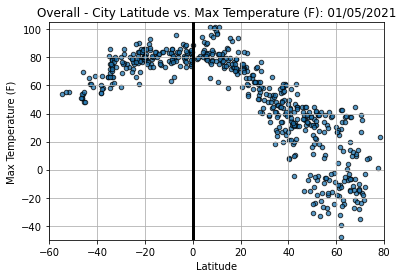

In [11]:
buildLatPlot("Max Temp", "Max Temperature (F)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's maximum temperature and its latitude. Overall, the points are relatively tightly clustered with about 20 degrees Fahrenheit of separation between all cities at a specific latitude. This holds true from -60 degrees to about 25 degrees latitude where the variance begins to increase. The trend still holds true -- the closer to the equator, the greater the maximum temperature -- but above 25 degrees latitude, the correlation weakens slightly.

## Latitude vs. Humidity Plot

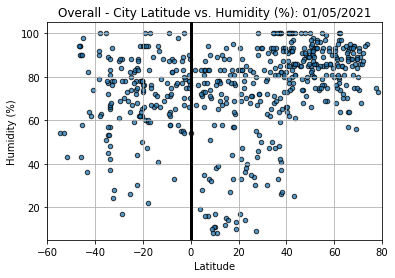

In [12]:
buildLatPlot("Humidity", "Humidity (%)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's humidity percentage and its latitude. Since the points are relatively spread out with a slightly more concentrated portion in the 50-70 degrees latitude and 70-90% humidity. This visual bunching may also just be a product of more cities getting included in that latitude. Overall, the correlation is very weak suggesting that latitude may not play a major role in a city's humidity. Further year-round testing would be needed to strengthen/debunk this observation.

## Latitude vs. Cloudiness Plot

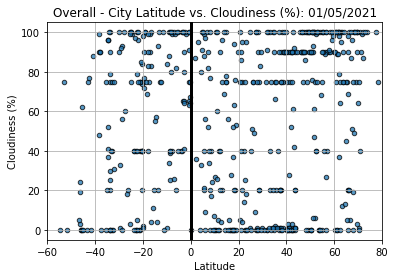

In [13]:
buildLatPlot("Cloudiness", "Cloudiness (%)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's cloudiness percentage and its latitude. As with humidity, more year-round data would be needed to develop an understanding as to whether latitude plays a role in cloudiness.

## Latitude vs. Wind Speed Plot

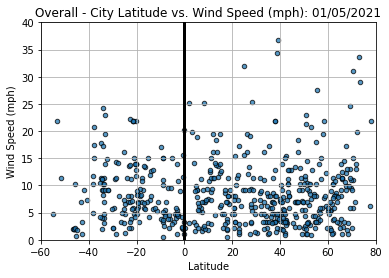

In [14]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", clean_city_df, title_prefix="Overall - ", grid=True, save=True)

##### Jan. 4th, 2021 Analysis:
This plot depicts the correlation between a city's wind speed and its latitude. Generally, the wind speed does not seem to be impacted by the latitude -- again, more year-round data would help with this claim. However, it is interesting to point out that the clear outliers (> 25mph) all exist outside of the tropics. May be a coincidence of the data pulled today, but might be something to look for in the future.

## Linear Regression

In [15]:
# Collect hemisphere-specific data
# Both include cities on the Equator
north_hemi_df = clean_city_df.loc[clean_city_df["Lat"] >= 0, :]
south_hemi_df = clean_city_df.loc[clean_city_df["Lat"] <= 0, :]

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: -0.8625528630364242


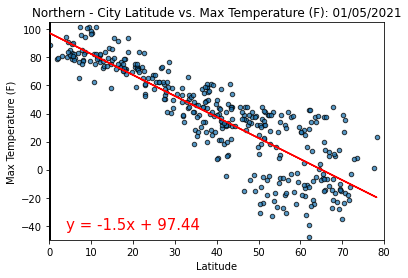

In [16]:
buildLatPlot("Max Temp", "Max Temperature (F)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-value is: 0.6834240779902804


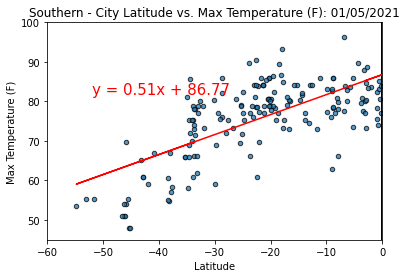

In [17]:
buildLatPlot("Max Temp", "Max Temperature (F)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.45339451412434073


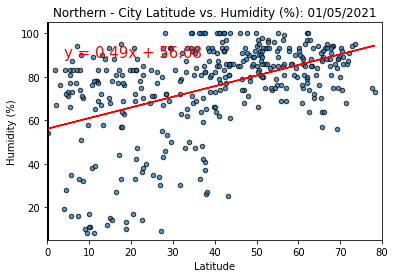

In [18]:
buildLatPlot("Humidity", "Humidity (%)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-value is: 0.10976575412888669


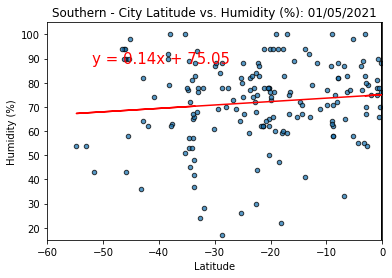

In [19]:
buildLatPlot("Humidity", "Humidity (%)",south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.2570122170231194


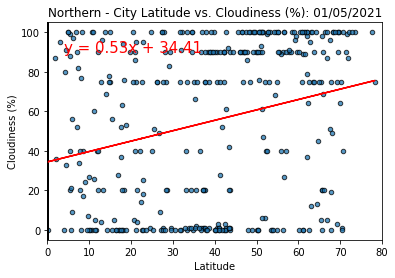

In [20]:
buildLatPlot("Cloudiness", "Cloudiness (%)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-value is: 0.3238712305184955


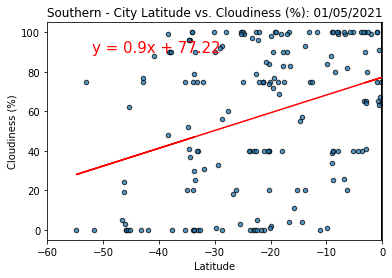

In [21]:
buildLatPlot("Cloudiness", "Cloudiness (%)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: 0.05136561027354944


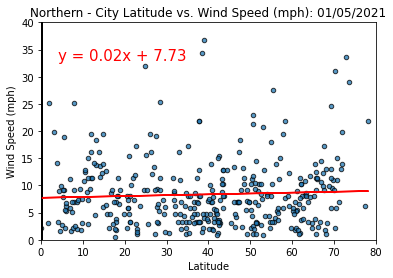

In [22]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", north_hemi_df, title_prefix="Northern - ", linregress=True, save=True)

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-value is: -0.09446827705149732


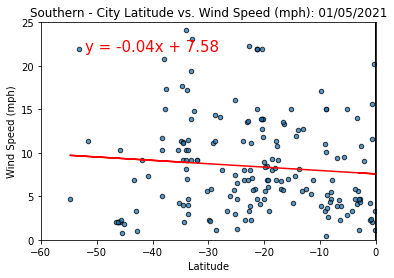

In [23]:
buildLatPlot("Wind Speed", "Wind Speed (mph)", south_hemi_df, title_prefix="Southern - ", linregress=True, save=True)